In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm

# Score



Training: 4 right answers

Evaluation: 10 right answers

Test: 0 right answers


# Idea

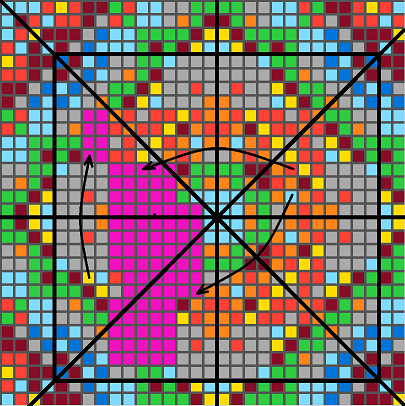


Find symmetric parts in the input matrix and replace 'extra' color.

**Main parts:**

1. Find submatrix with at least 1 type of symmetry (vertical, horizontal, main diagonal, side diagonal)
   We iterate row and column in the original matrix it will be left top corner of submatrix
   
   Submatrix always is a square matrix!
   
   Pseudo code:
     
       for sub_m_size in [min_sub_size, max_sub_size]:
           for i in [0, height]:
               for j in [0, width]:
                  sub_matrix = source_matrix[i: i + sub_m_size, j: j + sub_m_size]
   
2. Transfer axis of symmetry from sub matrix into original matrix
3. Check if we can replace all cells with extra color
4. Check that all train pairs solved right
5. In case we found answer apply it to the test, otherwise return None
6. Get 0 right answer on test 


I know it is a lot of code and could be solved with more simple algorithm but this approach works quite fast :)

Also it could be fine tuned because, there are a few samples where it works almost right, but not

Probably idea would be helpful for someone 


# ARC utils functions (read, plot, etc.)

In [ ]:
def get_input_matrix(json_file: dict, index: int) -> np.ndarray:
    return np.array(json_file['train'][index]['input'])

def get_input_matrices(json_file: dict) -> list:
    """
        Get all train input matrices from json file in list format

        Input:
            json_file: JSON file with 'train' filed
        Output:
            list of np.ndarrays, train input
    """
    res = []
    count_of_train_samples = len(json_file['train'])

    for index in range(count_of_train_samples):
        res.append(get_input_matrix(json_file, index))

    return res

def get_output_matrix(json_file: dict, index: int) -> np.ndarray:
    return np.array(json_file['train'][index]['output'])

def get_output_matrices(json_file: dict):
    """
        Get all train output matrices from json file in list format

        Input:
            json_file: JSON file with 'train' filed
        Output:
            list of np.ndarrays, train outputs
    """
    res = []
    count_of_test_samples = len(json_file['train'])

    for index in range(count_of_test_samples):
        res.append(get_output_matrix(json_file, index))

    return res


def get_input_matrix_test(json_file: dict, index: int) -> np.ndarray:
    """
        Get input matrix from test

        Input:
            json_file: json object - python dict
        Output:
            numpy ndarray
    """
    return np.array(json_file['test'][index]['input'])

def get_output_matrix_test(json_file: dict, index: int) -> np.ndarray:
    """
        Get output matrix from test

        Input:
            json_file: json object - python dict
        Output:
            numpy ndarray
    """
    return np.array(json_file['test'][index]['output'])


def get_input_matrices_test(json_file: dict) -> list:
    """
        Get all test input matrices from json file in list format

        Input:
            json_file: JSON file with 'train' filed
        Output:
            list of np.ndarrays, test inputs
    """
    res = []
    count_of_test_samples = len(json_file['test'])

    for index in range(count_of_test_samples):
        res.append(get_input_matrix_test(json_file, index))

    return res

def get_output_matrices_test(json_file: dict):
    """
        Get all test input matrices from json file in list format

        Input:
            json_file: JSON file with 'train' filed
        Output:
            list of np.ndarrays, test inputs
    """
    res = []
    count_of_test_samples = len(json_file['test'])

    for index in range(count_of_test_samples):
        res.append(get_output_matrix_test(json_file, index))

    return res

def load_task(json_file_path: str) -> tuple:
    """
        Get train inp/out matrices and test inp matrices

        Input:
            json_file_path: full path to json file with task
        Output:
            tuple:
                1. List of train input matrices each matrix np.ndarray
                2. List of train output matrices each matrix np.ndarray
                3. List of test input matrices each matrix np.ndarray
    """


    with open(json_file_path, 'r') as jfile:
        json_file = json.load(jfile)

        train_input_matrices  = get_input_matrices(json_file)
        train_output_matrices = get_output_matrices(json_file)
        test_input_matrices   = get_input_matrices_test(json_file)

        return (train_input_matrices, train_output_matrices, test_input_matrices)
    
cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)

def plot_matrix(matrix, subplot_num = 111, title = ''):
    ax = plt.subplot(subplot_num)
    plt.title(title)
    ax.imshow(matrix, cmap = cmap, norm = norm)
    ax.grid(True, which = 'both', color = 'black', linewidth = 0.7)
    ax.set_yticks([x - 0.5 for x in range(len(matrix) + 1)])
    ax.set_xticks([x - 0.5 for x in range(len(matrix[0]) + 1)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def make_output(matrix: np.ndarray) -> str:
    """ Create output in the right form """

    if (matrix is None):
        return '||'

    rows = ''

    for row in matrix:
        rows += str(row)

    rows = rows.replace(' ', '')
    rows = rows.replace('][', '|')
    rows = rows.replace('[[', '|')
    rows = rows.replace('[', '|')
    rows = rows.replace(']]', '|')
    rows = rows.replace(']', '|')

    return rows

def check_size_1piece(input_matrices: list, output_matrices: list) -> bool:
    """
        Check that output matrix has the same size with input
    """

    for inp, out in zip(input_matrices, output_matrices):

        vertical_ratio = out.shape[0] / inp.shape[0]
        horizontal_ration = out.shape[1] / inp.shape[1]

        cond1 = vertical_ratio == horizontal_ration and vertical_ratio == 1

        if not cond1:
            return False

    return True

# Helper functions for the algorithm

**is_similar** function just checks can we create arr2 from arr1 or (arr1 from arr2) if we change cells with an 'extra_color'

One of two arrays should not have any cells with 'extra_color'

In [ ]:
def is_similar(arr1: np.ndarray, arr2: np.ndarray, extra_color: int, min_possible_elements = 9) -> bool:
    """
        Check that 2 arrays are equal except extra_color

        Actually we try to find is it possible
        to fill extra color in one array with elements from an other array

        Input:
            arr1, arr2: numpy arrays which will compare
            extra_color: int should be in [0-9] this color we don't take into account
            min_possible_elements:  a minimum number of elements != extra_color which has to be equal
        Output:
            False: if array

    """

    if (arr1.size != arr2.size or arr1.size == 0 or arr1.ndim != 1 or arr2.ndim != 1):
        return False
    if (np.any(arr1 == extra_color) and np.any(arr2 == extra_color)):
        return False

    count_equal = 0

    for i in range(arr1.shape[0]):
        if (arr1[i] == extra_color or arr2[i] == extra_color):
            continue
        if (arr1[i] != arr2[i]):
            return False

        count_equal += 1

    return count_equal >= min_possible_elements

**find_equal_segment** It is supposed that bad_segment is 1d array and has some cells with an extra color. We are trying find another 1d array which be the same but without extra color

In [ ]:
def find_equal_segment(inp: np.ndarray, bad_segment: np.ndarray, extra_color: int) -> np.ndarray:
    """
        Function tries to find segment similar to bad_segment bad without extra_color
        we suppose that cells == extra_color are just empty cells

        Input:
            inp: matrix where we search for good_segment
            bad_segment: 1d row or col from input matrix where we wanna replace extra_color
            extra_color: the color which we wanna replace
        Output:
            None if found nothing
            or
            1d np.ndarray which is equal with bad_segment bad without extra_color
            size(bad_segment) = size(returned segment)
    """

    segment_len = bad_segment.size

    # trying to find on rows
    for i in range(inp.shape[0]):
        for col in range(inp.shape[1] - segment_len + 1):
            current_segment = inp[i, col:col + segment_len]
            if (is_similar(current_segment, bad_segment, extra_color)):
                return current_segment

    # trying to find on columns
    for j in range(inp.shape[1]):
        for row in range(inp.shape[0] - segment_len + 1):
            current_segment = inp[row:row + segment_len, j]
            if (is_similar(current_segment, bad_segment, extra_color)):
                return current_segment

    return None

In [ ]:
def is_symmetric(matrix: np.ndarray, symmetric_type: int) -> tuple:
    """
        Check if input matrix has symmetry or not
        Matrix can have asymmetric parts algo looks on the whole matrix

        Input:
            matrix: ndarray SQUARE matrix
            symmetric_type: which kind of symmetry should be in matrix
                1. Horizontal (left and right cells are equal)
                2. Vertical (upper and lower cells are equal)
                3. Main diagonal (only for NxN matrices, cells are equal with respect to main diagonal)
                4. Side diagoanl (only for NxN matrices, cells are equal with respect to side diagonal)
        Output
            Tuple:
                1) True: if matrix is symmetrical
                   False: otherwise
                2) Most popular color for unsymmetric cases
    """

    colors = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # how many elements are symmetric
    equal = 0
    # count of all elements
    total = 0

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):

            cell = matrix[i][j]

            if (symmetric_type == 1): # horizontal
                opposite_cell = matrix[matrix.shape[0] - i - 1][j]
            elif(symmetric_type == 2): #vertical
                opposite_cell = matrix[i][matrix.shape[1] - j - 1]
            elif(symmetric_type == 3): # main diagonal
                opposite_cell = matrix[j][i]
            else:
                opposite_cell = matrix[matrix.shape[0] - j - 1][matrix.shape[1] - i - 1]

            if (cell == opposite_cell):
                equal += 1
            else:
                colors[cell] += 1
                colors[opposite_cell] += 1

            total += 1

    max_color = 0

    for i in range(len(colors)):
        if (colors[i] > colors[max_color]):
            max_color = i

    # 0.6 means 60% of equal elements of all, you can change it in [0, 1]
    if (equal / total > 0.6):
        return (True, max_color)
    else:
        return (False, max_color)

**delete_extra_color** We use this function on the final step when we have already applied base algo and have some cells with an extra color. It is brutoforce function which is trying to find equal 1d parts and correct wrong one

In [ ]:
def delete_extra_color(inp: np.ndarray, extra_color: int):
    """
        [Inplace function]
    
        This function tries to replace extra color in the input matrix
        by finding equal rows and cols

        Input:
            inp: input matrix with extra_color which we want to replace
            extra_color: number [0-9] which we want to replace in the input matrix
        Output:
            No output, this function directly changes input matrix

    """

    bad_rows, bad_cols = np.where(inp == extra_color)

    bad_rows = np.unique(bad_rows)
    bad_cols = np.unique(bad_cols)

    if (len(bad_rows) > inp.shape[0] // 2 or len(bad_cols) > inp.shape[0] // 2):
        return

    for i in bad_rows:
        for segment_len in range(10, inp.shape[1] + 1, 1):
            for col in range(inp.shape[1] - segment_len + 1):
                bad_segment = inp[i, col: col + segment_len]

                if (not np.any(bad_segment == extra_color)):
                    continue

                correct_segment = find_equal_segment(inp, bad_segment, extra_color)

                if (correct_segment is not None):
                    inp[i, col:col + segment_len] = correct_segment

    for j in bad_cols:
        for segment_len in range(10, inp.shape[0] + 1, 1):
            for row in range(inp.shape[0] - segment_len + 1):
                bad_segment = inp[row:row + segment_len, j]

                if (not np.any(bad_segment == extra_color)):
                    continue

                correct_segment = find_equal_segment(inp, bad_segment, extra_color)

                if (correct_segment is not None):
                    inp[row:row + segment_len, j] = correct_segment


# Make a prediction then we know parameters of symmetry

In this function we are trying to replace cells with *extra_color*

We have input matrix and a few extra parameters. 

In [ ]:
def prediction(inp: np.ndarray,
                    symmetric_axis_horizontal: list,
                    symmetric_axis_vertical: list,
                    symmetric_main_diagonal: bool,
                    symmetric_side_diagonal: bool,
                    shift_i: int,
                    shift_j: int,
                    size: int,
                    extra_color: int) -> bool:
    """
        Make a prediction for one matrix

        Find cells with extra_color and fill them with
        right color from symmetric cells

        Input:
            inp: matrix which we want to change

        Output:
            changed input matrix
    """

    res = inp.copy()

    for i in range(inp.shape[0]):
        for j in range(inp.shape[1]):

            # it's a good cell
            if (inp[i][j] != extra_color):

                res[i][j] = inp[i][j]
                continue

            if symmetric_axis_horizontal is not None:
                if (symmetric_axis_horizontal[1] != 0):
                    vertical_len = min(abs(i - symmetric_axis_horizontal[0]), abs(i - symmetric_axis_horizontal[1]))

                    row = i + vertical_len * 2 + 1
                    if (i >= symmetric_axis_horizontal[1]):
                        row = i - vertical_len * 2 - 1

                    if (0 <= row and row < inp.shape[0] and inp[row][j] != extra_color):
                        res[i][j] = inp[row][j]
                else:
                    vertical_len = abs(i - symmetric_axis_horizontal[0])

                    row = i + vertical_len * 2
                    if (i >= symmetric_axis_horizontal[0]):
                        row = i - vertical_len * 2

                    if (0 <= row and row < inp.shape[0] and inp[row][j] != extra_color):
                        res[i][j] = inp[row][j]

            if symmetric_axis_vertical is not None:
                if (symmetric_axis_vertical[1] != 0):
                    horizontal_len = min(abs(j - symmetric_axis_vertical[0]), abs(j - symmetric_axis_vertical[1]))

                    column = j + horizontal_len * 2 + 1

                    if (j >= symmetric_axis_vertical[1]):
                        column = j - horizontal_len * 2 - 1

                    if (0 <= column and column < inp.shape[1] and inp[i][column] != extra_color):
                        res[i][j] = inp[i][column]
                else:
                    horizontal_len = abs(j - symmetric_axis_vertical[0])

                    column = j + horizontal_len * 2
                    if (j >= symmetric_axis_vertical[0]):
                        column = j - horizontal_len * 2

                    if (0 <= column and column < inp.shape[1] and inp[i][column] != extra_color):
                        res[i][j] = inp[i][column]

            if (symmetric_main_diagonal):

                if i - shift_i > j - shift_j:
                    new_i = j + abs(shift_j - shift_i)
                    new_j = i - abs(shift_j - shift_i)
                elif i - shift_i < j - shift_j:
                    new_i = j - abs(shift_j - shift_i)
                    new_j = i + abs(shift_j - shift_i)
                else:
                    new_i, new_j = -1, -1

                if (0 <= new_i and new_i < inp.shape[0] and 0 <= new_j and new_j < inp.shape[1] and inp[new_i][new_j] != extra_color):
                    res[i][j] = inp[new_i][new_j]

            if (symmetric_side_diagonal):

                side_diag_sum = shift_i + shift_j + size - 1
                delta = side_diag_sum - i - j

                if (delta % 2 == 0):
                    if(delta > 0):
                        delta += 1
                    elif(delta < 0):
                        delta -= 1

                new_i = i + delta
                new_j = j + delta

                if (0 <= new_i and new_i < inp.shape[0] and 0 <= new_j and new_j < inp.shape[1] and
                        inp[new_i][new_j] != extra_color):
                    res[i][j] = inp[new_i][new_j]

    if (np.any(res == extra_color)):
        delete_extra_color(res, extra_color)

    return res

In this part we are trying to choose submatrix with symmetry and restore the input matrix via 
symmetry lines

# Main logic of the algo



Here we take input and output matrices and do magic

In [ ]:
def find_restored_matrix(inp: np.ndarray, out: np.ndarray, mode = 'train') -> list:
    """
        This function tries to restore input matrix
        i.e to fill "empty" places where are placed incorrect color

        Input:
            inp: 2d input matrix
            out: 2d output matrix how should look input matrix after all manipulations
            mode: 'train' in this case we also check inp and out
                  'test' in this case we just return predicted matrix

    """
    
    # 11 chosen by hands
    min_possible_size = max(11, inp.shape[0] // 2)

    # let's try to find maximum size of sub matrix with symmetry
    for size in range(min_possible_size, inp.shape[0] + 1, 1):

        # for each matrix we should know lines of symmetry
        symmetric_axis_horizontal = None
        symmetric_axis_vertical = None

        for i in range(inp.shape[0] - size + 1):
            for j in range(inp.shape[1] - size + 1):

                sub_matrix = inp[i:i + size, j:j + size].copy()

                result_horizontal = is_symmetric(sub_matrix, 1)
                result_vertical   = is_symmetric(sub_matrix, 2)
                result_main_diag  = is_symmetric(sub_matrix, 3)
                result_side_diag  = is_symmetric(sub_matrix, 4)

                if (result_horizontal[0]):
                    extra_color = result_horizontal[1]
                elif (result_vertical[0]):
                    extra_color = result_vertical[1]
                elif (result_main_diag[0]):
                    extra_color = result_main_diag[1]
                elif (result_side_diag[0]):
                    extra_color = result_side_diag[1]
                else:
                    break

                if (result_horizontal[0] and extra_color != result_horizontal[1]):
                    break
                if (result_vertical[0] and extra_color != result_vertical[1]):
                    break
                if (result_main_diag[0] and extra_color != result_main_diag[1]):
                    break
                if (result_side_diag[0] and extra_color != result_side_diag[1]):
                    break

                if (size % 2 == 0):

                    vertical_index = [0, 0]
                    vertical_index[0] = (j + j + size) // 2 - 1
                    vertical_index[1] = (j + j + size) // 2

                    horizontal_index = [0, 0]
                    horizontal_index[0] = (i + i + size) // 2 - 1
                    horizontal_index[1] = (i + i + size) // 2

                    if (result_horizontal[0]):
                        symmetric_axis_horizontal = horizontal_index
                    if (result_vertical[0]):
                        symmetric_axis_vertical = vertical_index
                else:
                    vertical_index = (j + j + size) // 2
                    horizontal_index = (i + i + size) // 2

                    if (result_horizontal[0]):
                        symmetric_axis_horizontal = [horizontal_index, 0]
                    if (result_vertical[0]):
                        symmetric_axis_vertical = [vertical_index, 0]

                cur = prediction(inp, symmetric_axis_horizontal, symmetric_axis_vertical,
                                    result_main_diag[0], result_side_diag[0], i, j, size, extra_color)

                if (np.any(cur == extra_color)):
                    continue

                if (mode == 'train' and np.array_equal(cur, out)):
                    return cur
                elif (mode == 'test'):
                    return cur

    return None

# Iterate over train pairs and apply algo



Here we take data for the current task and apply a few methods to find answer

In [ ]:
def symmetry_algo(train_in: list, train_out: list, test_in: list) -> list:
    """
        Find symmetry and fill empty cells

        Tasks Evalutaion: 47996f11.json 4aab4007.json 903d1b4a.json
                          929ab4e9.json 981571dc.json af22c60d.json
                          ca8f78db.json e95e3d8e.json f823c43c.json
                          f9d67f8b.json

        Input:
            train_in:  list of np.ndarray train samples
            train_out: list of np.ndarray train samples output
            test_in:   list of np.ndarray test sample.
        Output:
            test_out: list of np.ndarray test output matrices
    """

    for inp, out in zip(train_in, train_out):
        
        # 11 chosen by hands :)
        if (inp.shape[0] < 11):
            return None

        predict = find_restored_matrix(inp, out)

        if (predict is None):
            return None

    result = []
    
    for test_inp in test_in:

        if (test_inp.shape[0] < 11):
            return None

        predict = find_restored_matrix(test_inp, inp, mode = 'test')

        if (predict is None):
            return None

        result.append(predict)


    return result

# Testing part 



Here we iterate over all samples and make predictions 

In [ ]:
data_folder = '../input/abstraction-and-reasoning-challenge/evaluation/'

results = pd.DataFrame(columns = ('output_id', 'output'))

mode = 'Train' # use 'Train' if wanna see statistics, any other string in case of getting results on the test set

correct_predictions = 0
total_predictions = 0

# go through tasks in data_folder
for filename in tqdm(os.listdir(data_folder)):
    
    full_path = os.path.join(data_folder, filename)

    train_input_matrices, train_output_matrices, test_input_matrices = load_task(full_path)
    
    
    if (mode == 'Train'):
    
        with open(full_path, 'r') as jfile:
            json_file = json.load(jfile)
    
        test_output_matrices = get_output_matrices_test(json_file)
    
    solution_found = False
    
    if (check_size_1piece(train_input_matrices, train_output_matrices)):
        
        predictions = symmetry_algo(train_input_matrices, train_output_matrices, test_input_matrices)
        
        total_predictions += len(test_input_matrices)
        
        if predictions is not None:
            
            print('Found for: ', filename)
            
            solution_found = True
            
            for ind, test_out in enumerate(predictions):

                # separate filename from '.json'
                filename = filename.split('.')[0]
                results = results.append({'output_id': filename + '_' + str(ind), 'output': make_output(test_out)}, ignore_index = True)
                
                if (mode == 'Train'):
                    
                    if (np.array_equal(test_out, test_output_matrices[ind])):
                        correct_predictions += 1
                        plt.figure(figsize = (10, 5), dpi = 150)
                        plot_matrix(test_input_matrices[ind], 131, 'Test input matrix')
                        plot_matrix(test_output_matrices[ind], 132, 'Test output matrix')
                        plot_matrix(test_out, 133, 'Test predicted matrix')
                        plt.show()
                
    
    if (not solution_found):

        # define empty predictions
        predictions = np.array([])

        for ind in range(len(test_input_matrices)):
            # we found nothing
            results = results.append({'output_id': filename.split('.')[0] + '_' + str(ind), 'output': make_output(predictions)}, ignore_index = True)

if (mode == 'Train'):
    print(f'Solved {correct_predictions} of {total_predictions}')
            
results.to_csv('submission.csv', index = False)